In [44]:
import pytorch_lightning as pl
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from sklearn.metrics import confusion_matrix

from umap import UMAP

from gratin.simulation.diffusion_models import generators, ML_alpha
from gratin.training.utils import setup_model_and_dm, setup_trainer
from gratin.models.utils import get_predictions_of_dl
from gratin.models.network_lightning import MainNet
import os

%config InlineBackend.figure_format = 'png'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters

In [2]:
net_params = {"latent_dim":32, # Dimension of the latent space
                "n_c":32} # Number of convolution channels

dl_params = {"batch_size":128, 
             "num_workers":10} # parallelization of data loading

graph_info = {"edges_per_point":20, # If L <= edges_per_point, use the complete graph
                "clip_trajs":True, # To limit rare events impact
                "scale_types":["step_std","step_mean","pos_std"], # Different normalization methods to use
                "log_features":True, # Whether to use raw features (False) or log10(features) (True), for features which are always positive
                "edge_method":"geom_causal"} # Wiring pattern to use

ds_params = {"dim":2, # Dimension of the walks : 1, 2 or 3
        "RW_types":["ATTM","fBM","CTRW","LW","sBM"], # Random walk models to include
        "N":int(1e5), # number of trajectories per training epoch. Trajectories are generated on the fly.
        "length_range":(10,100), # length range to train on. Length is sampled uniformly between these bounds
        "drift_range": (0.,0.), # Not used
        "noise_range":(0.1,1.)} # Noise factor is drawn uniformly in these bounds

tasks = ["alpha","model"] # Tasks to train for

# Setup model

[autoreload of gratin.data.data_classes failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: setup() requires a code object with 1 free vars, 

stage is None, strange...


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores


f size =  [50, 128, 64, 32]
Convolution has 17462 parameters. Input dim is 25, output is 32
f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Input dim is 32, output is 32
f size =  [128, 128, 64, 32]
Convolution has 27680 parameters. Input dim is 64, output is 32
alpha MLP size =  [32, 128, 128, 64, 16, 1]
Alpha predictor has 30723 parameters


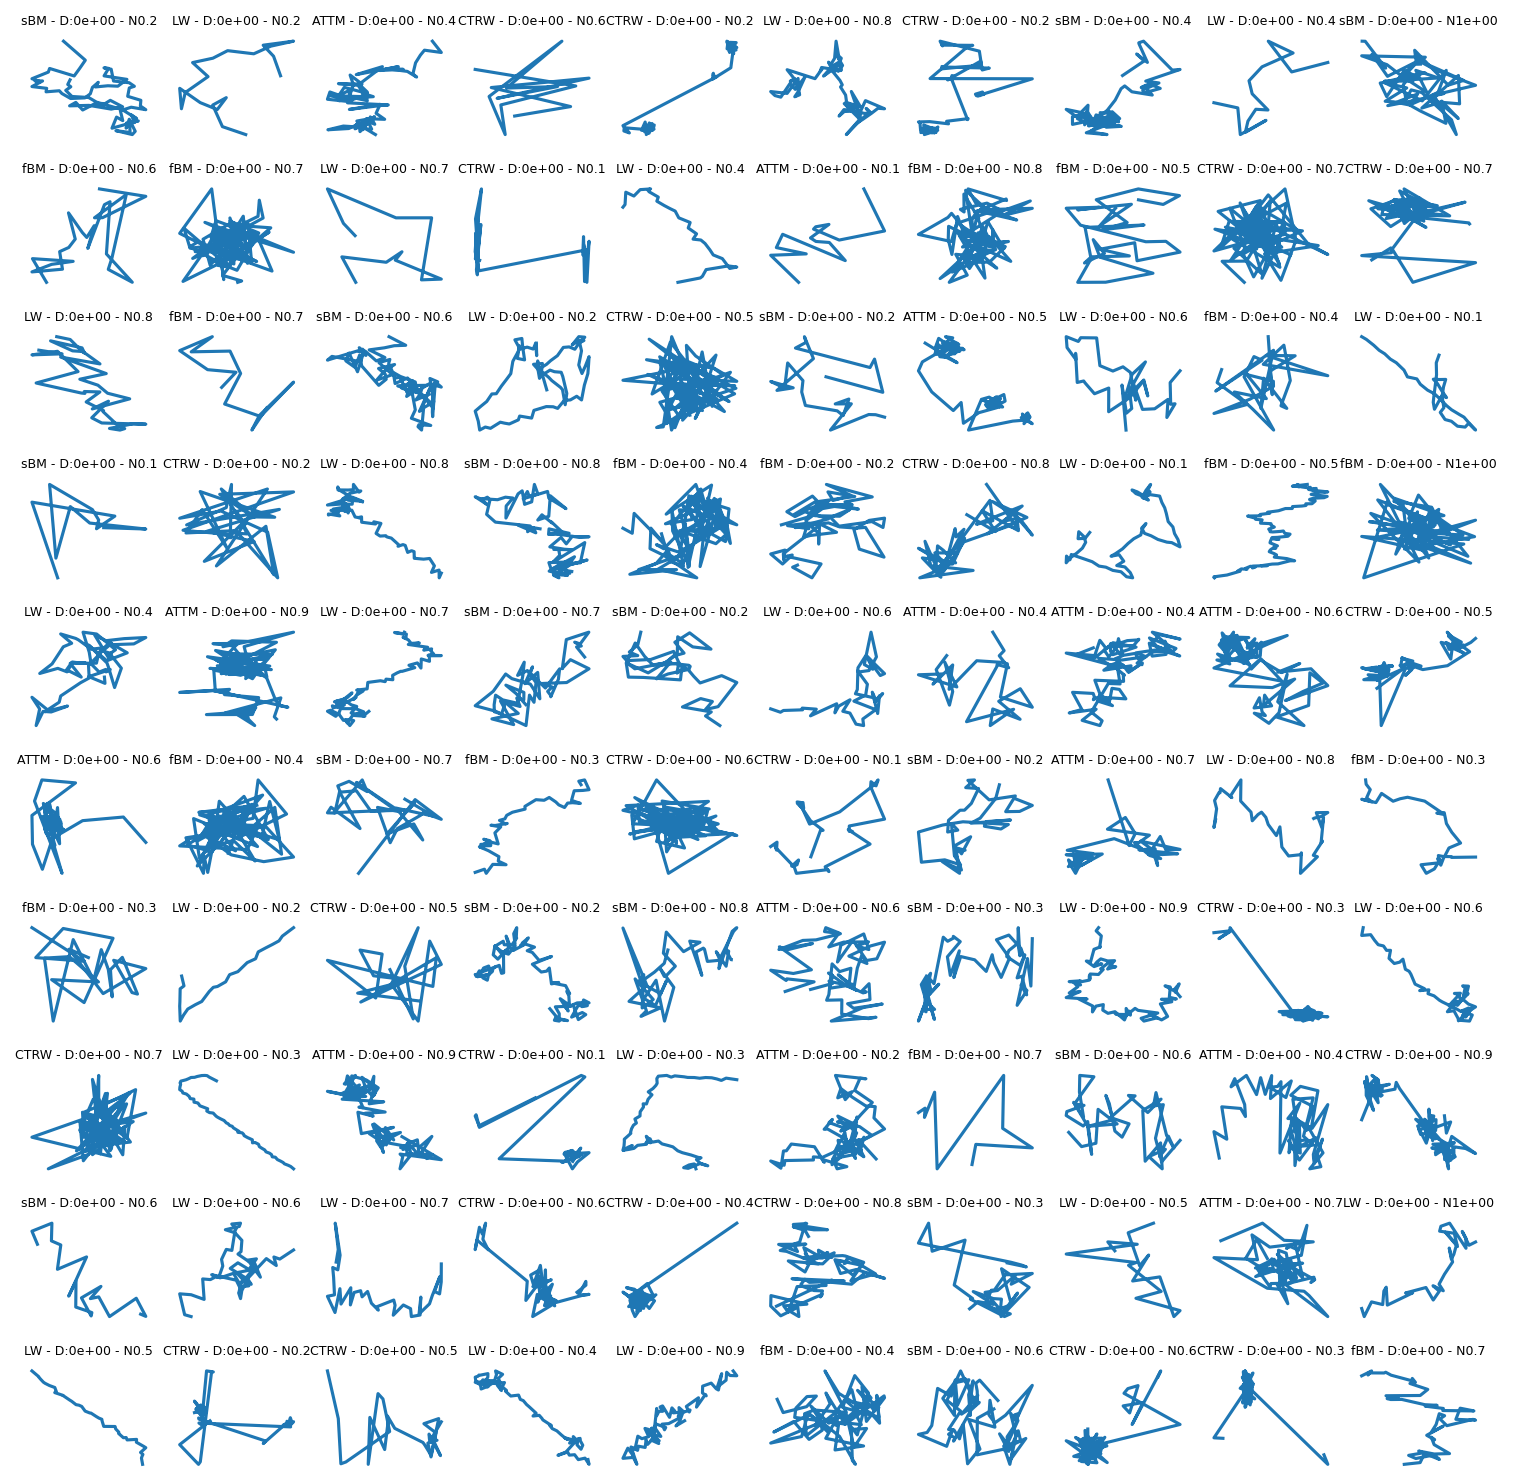

In [4]:
model, dm = setup_model_and_dm(tasks, ds_params, net_params, dl_params, graph_info)

TAG = "example" # your tag here
TB_DIR = "/gaia/tb_logs"
CKPT_DIR = "/gaia/models"

tb_logger = pl.loggers.TensorBoardLogger(save_dir=TB_DIR,default_hp_metric=False,name=TAG)
trainer = setup_trainer(tb_logger,dirpath=CKPT_DIR,tag=TAG)

# Training

In [ ]:
trainer.fit(model=model,datamodule=dm)

Global seed set to 1234
INFO:lightning:Global seed set to 1234
initializing ddp: GLOBAL_RANK: 0, MEMBER: 1/1
INFO:lightning:initializing ddp: GLOBAL_RANK: 0, MEMBER: 1/1

    | Name                          | Type              | Params
----------------------------------------------------------------------
0   | encoder                       | TrajsEncoder      | 71.4 K
1   | encoder.conv1                 | MinimalJumpsConv  | 17.5 K
2   | encoder.conv1.bn_x            | BatchNorm1d       | 50    
3   | encoder.conv1.f               | Sequential        | 17.4 K
4   | encoder.conv1.f.0             | BatchNorm1d       | 100   
5   | encoder.conv1.f.1             | Sequential        | 17.3 K
6   | encoder.conv1.f.1.0           | Sequential        | 6.8 K 
7   | encoder.conv1.f.1.0.0         | Dropout           | 0     
8   | encoder.conv1.f.1.0.1         | Linear            | 6.5 K 
9   | encoder.conv1.f.1.0.2         | BatchNorm1d       | 256   
10  | encoder.conv1.f.1.0.3         | Leaky

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 703: train_loss reached 2.23104 (best 2.23104), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 0, global step 703: train_loss reached 2.23104 (best 2.23104), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 1407: train_loss reached 2.11368 (best 2.11368), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 1, global step 1407: train_loss reached 2.11368 (best 2.11368), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 2111: train_loss reached 2.08277 (best 2.08277), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 2, global step 2111: train_loss reached 2.08277 (best 2.08277), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 2815: train_loss reached 2.04977 (best 2.04977), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 3, global step 2815: train_loss reached 2.04977 (best 2.04977), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 3519: train_loss reached 2.03203 (best 2.03203), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 4, global step 3519: train_loss reached 2.03203 (best 2.03203), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 4223: train_loss reached 1.99684 (best 1.99684), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 5, global step 4223: train_loss reached 1.99684 (best 1.99684), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 4927: train_loss reached 1.97044 (best 1.97044), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 6, global step 4927: train_loss reached 1.97044 (best 1.97044), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]

                                     Epoch 8, global step 6335: train_loss reached 1.94684 (best 1.94684), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 8, global step 6335: train_loss reached 1.94684 (best 1.94684), saving model to "/gaia/models/example-v4.ckpt" as top 1


module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'
Conflict between tensorboard and tensorflow (installed with umap-learn...)


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validating: 0it [00:00, ?it/s]

Epoch 13, global step 9855: train_loss reached 1.92103 (best 1.92103), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 13, global step 9855: train_loss reached 1.92103 (best 1.92103), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 10559: train_loss reached 1.91194 (best 1.91194), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 14, global step 10559: train_loss reached 1.91194 (best 1.91194), saving model to "/gaia/models/example-v4.ckpt" as top 1
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validating: 0it [00:00, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]

                                     Epoch 18, step 13375: train_loss was not in top 1
INFO:lightning:Epoch 18, step 13375: train_loss was not in top 1


module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'
Conflict between tensorboard and tensorflow (installed with umap-learn...)


Validating: 0it [00:00, ?it/s]

Epoch 19, step 14079: train_loss was not in top 1
INFO:lightning:Epoch 19, step 14079: train_loss was not in top 1
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validating: 0it [00:00, ?it/s]

Epoch 24, global step 17599: train_loss reached 1.87097 (best 1.87097), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 24, global step 17599: train_loss reached 1.87097 (best 1.87097), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 18303: train_loss reached 1.86636 (best 1.86636), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 25, global step 18303: train_loss reached 1.86636 (best 1.86636), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 19007: train_loss reached 1.85763 (best 1.85763), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 26, global step 19007: train_loss reached 1.85763 (best 1.85763), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, step 19711: train_loss was not in top 1
INFO:lightning:Epoch 27, step 19711: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]

                                     Epoch 28, global step 20415: train_loss reached 1.85715 (best 1.85715), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 28, global step 20415: train_loss reached 1.85715 (best 1.85715), saving model to "/gaia/models/example-v4.ckpt" as top 1


module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'
Conflict between tensorboard and tensorflow (installed with umap-learn...)


Validating: 0it [00:00, ?it/s]

Epoch 29, step 21119: train_loss was not in top 1
INFO:lightning:Epoch 29, step 21119: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 21823: train_loss reached 1.85458 (best 1.85458), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 30, global step 21823: train_loss reached 1.85458 (best 1.85458), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 22527: train_loss reached 1.84496 (best 1.84496), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 31, global step 22527: train_loss reached 1.84496 (best 1.84496), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, step 23231: train_loss was not in top 1
INFO:lightning:Epoch 32, step 23231: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, step 23935: train_loss was not in top 1
INFO:lightning:Epoch 33, step 23935: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, step 24639: train_loss was not in top 1
INFO:lightning:Epoch 34, step 24639: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 35, step 25343: train_loss was not in top 1
INFO:lightning:Epoch 35, step 25343: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, step 26047: train_loss was not in top 1
INFO:lightning:Epoch 36, step 26047: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 26751: train_loss reached 1.84253 (best 1.84253), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 37, global step 26751: train_loss reached 1.84253 (best 1.84253), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]

                                     Epoch 38, step 27455: train_loss was not in top 1
INFO:lightning:Epoch 38, step 27455: train_loss was not in top 1


module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'
Conflict between tensorboard and tensorflow (installed with umap-learn...)


Validating: 0it [00:00, ?it/s]

Epoch 39, step 28159: train_loss was not in top 1
INFO:lightning:Epoch 39, step 28159: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 28863: train_loss reached 1.82687 (best 1.82687), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 40, global step 28863: train_loss reached 1.82687 (best 1.82687), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 41, step 29567: train_loss was not in top 1
INFO:lightning:Epoch 41, step 29567: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 42, step 30271: train_loss was not in top 1
INFO:lightning:Epoch 42, step 30271: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 43, step 30975: train_loss was not in top 1
INFO:lightning:Epoch 43, step 30975: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 44, step 31679: train_loss was not in top 1
INFO:lightning:Epoch 44, step 31679: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 45, step 32383: train_loss was not in top 1
INFO:lightning:Epoch 45, step 32383: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 46, step 33087: train_loss was not in top 1
INFO:lightning:Epoch 46, step 33087: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 47, step 33791: train_loss was not in top 1
INFO:lightning:Epoch 47, step 33791: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]

                                     Epoch 48, global step 34495: train_loss reached 1.82637 (best 1.82637), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 48, global step 34495: train_loss reached 1.82637 (best 1.82637), saving model to "/gaia/models/example-v4.ckpt" as top 1


module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'
Conflict between tensorboard and tensorflow (installed with umap-learn...)


Validating: 0it [00:00, ?it/s]

Epoch 49, global step 35199: train_loss reached 1.82458 (best 1.82458), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 49, global step 35199: train_loss reached 1.82458 (best 1.82458), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 50, global step 35903: train_loss reached 1.81966 (best 1.81966), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 50, global step 35903: train_loss reached 1.81966 (best 1.81966), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 51, global step 36607: train_loss reached 1.81944 (best 1.81944), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 51, global step 36607: train_loss reached 1.81944 (best 1.81944), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 52, step 37311: train_loss was not in top 1
INFO:lightning:Epoch 52, step 37311: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 53, global step 38015: train_loss reached 1.81301 (best 1.81301), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 53, global step 38015: train_loss reached 1.81301 (best 1.81301), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 54, step 38719: train_loss was not in top 1
INFO:lightning:Epoch 54, step 38719: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 55, global step 39423: train_loss reached 1.80825 (best 1.80825), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 55, global step 39423: train_loss reached 1.80825 (best 1.80825), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 56, step 40127: train_loss was not in top 1
INFO:lightning:Epoch 56, step 40127: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 57, step 40831: train_loss was not in top 1
INFO:lightning:Epoch 57, step 40831: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]

                                     Epoch 58, step 41535: train_loss was not in top 1
INFO:lightning:Epoch 58, step 41535: train_loss was not in top 1


module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'
Conflict between tensorboard and tensorflow (installed with umap-learn...)


Validating: 0it [00:00, ?it/s]

Epoch 59, step 42239: train_loss was not in top 1
INFO:lightning:Epoch 59, step 42239: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 60, global step 42943: train_loss reached 1.80761 (best 1.80761), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 60, global step 42943: train_loss reached 1.80761 (best 1.80761), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 61, global step 43647: train_loss reached 1.79722 (best 1.79722), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 61, global step 43647: train_loss reached 1.79722 (best 1.79722), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 62, step 44351: train_loss was not in top 1
INFO:lightning:Epoch 62, step 44351: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 63, step 45055: train_loss was not in top 1
INFO:lightning:Epoch 63, step 45055: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 64, global step 45759: train_loss reached 1.79369 (best 1.79369), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 64, global step 45759: train_loss reached 1.79369 (best 1.79369), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 65, step 46463: train_loss was not in top 1
INFO:lightning:Epoch 65, step 46463: train_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 66, global step 47167: train_loss reached 1.79299 (best 1.79299), saving model to "/gaia/models/example-v4.ckpt" as top 1
INFO:lightning:Epoch 66, global step 47167: train_loss reached 1.79299 (best 1.79299), saving model to "/gaia/models/example-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 67, step 47871: train_loss was not in top 1
INFO:lightning:Epoch 67, step 47871: train_loss was not in top 1


In [6]:
trainer.test()

Global seed set to 1234
INFO:lightning:Global seed set to 1234


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'alpha_test_loss': 0.9260284304618835,
 'model_test_loss': 0.8366450667381287,
 'test_F1': 0.6340413093566895,
 'test_MAE': 0.25949057936668396,
 'test_loss': 1.7626734972000122}
--------------------------------------------------------------------------------


[{'test_loss': 1.7626734972000122,
  'alpha_test_loss': 0.9260284304618835,
  'test_MAE': 0.25949057936668396,
  'model_test_loss': 0.8366450667381287,
  'test_F1': 0.6340413093566895}]

# Evaluate performance

In [58]:
# Load weights
model = MainNet.load_from_checkpoint("/gaia/models/%s-v4.ckpt" % TAG,dm=dm)
model.freeze()
dl = dm.test_dataloader(no_parallel=True)
outputs, info = get_predictions_of_dl(model, dl)

f size =  [50, 128, 64, 32]
Convolution has 17462 parameters. Input dim is 25, output is 32
f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Input dim is 32, output is 32
f size =  [128, 128, 64, 32]
Convolution has 27680 parameters. Input dim is 64, output is 32
alpha MLP size =  [32, 128, 128, 64, 16, 1]
Alpha predictor has 30723 parameters


  0%|          | 0/782 [00:00<?, ?it/s]

## On alpha

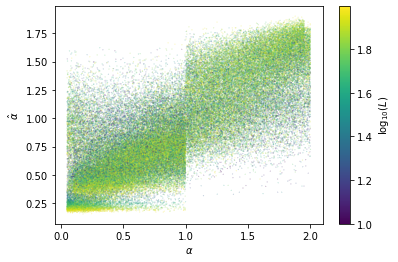

In [28]:
cm = plt.scatter(info["alpha"],outputs["alpha"],c=np.log10(info["length"]),s=.01)
plt.xlabel("$\\alpha$")
plt.ylabel("$\hat{\\alpha}$")
plt.colorbar(cm,label="$\log_{10}(L)$");

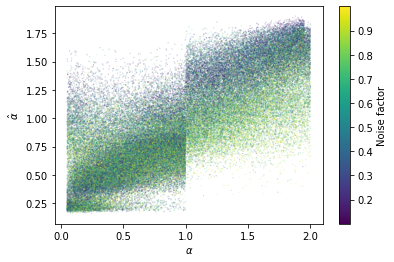

In [27]:
cm = plt.scatter(info["alpha"],outputs["alpha"],c=info["noise"],s=.01)
plt.xlabel("$\\alpha$")
plt.ylabel("$\hat{\\alpha}$")
plt.colorbar(cm,label="Noise factor");

We see below that a subset of random walks are completely stationnary

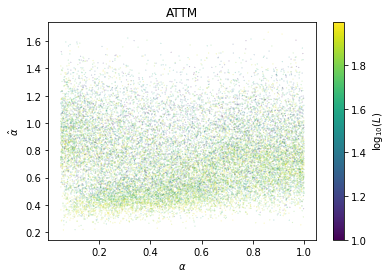

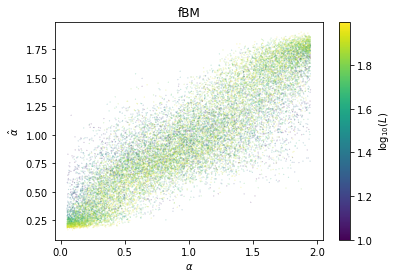

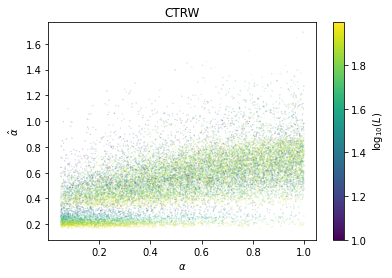

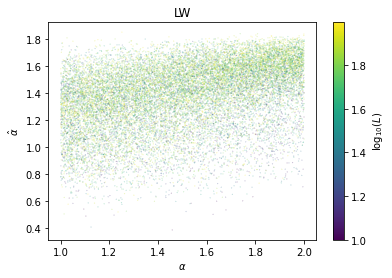

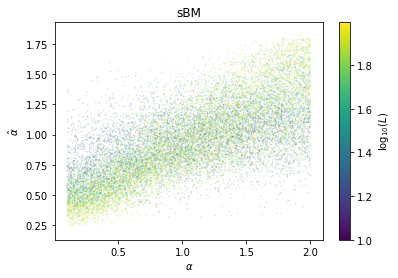

In [30]:
for m in np.unique(info["model"]):
    plt.figure()
    c = info["model"] == m
    cm = plt.scatter(info["alpha"][c],outputs["alpha"][c],c=np.log10(info["length"][c]),s=.01)
    plt.xlabel("$\\alpha$")
    plt.ylabel("$\hat{\\alpha}$")
    plt.colorbar(cm,label="$\log_{10}(L)$");
    plt.title(dl.dataset.model_types[m])

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


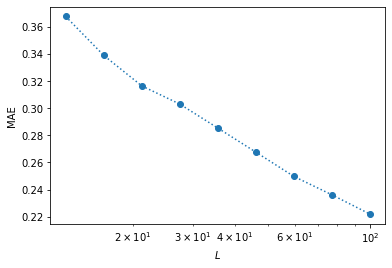

In [61]:
error = np.abs(info["alpha"]-outputs["alpha"])
bins = np.logspace(.99,2,10,endpoint=True)
idx = np.digitize(info["length"],bins)
plt.plot(bins,[np.mean(error[idx == i]) for i in range(len(bins))],":o")
plt.xlabel("$L$")
plt.ylabel("MAE")
plt.xscale("log");

## Classification

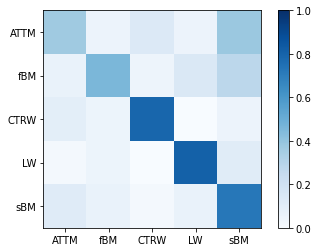

In [39]:
pred = np.argmax(outputs["model"], axis=1)
n_models = len(model.hparams["RW_types"])
CM = (
    confusion_matrix(info["model"], pred,normalize="true")
)

fig = plt.figure()
ax = fig.add_subplot(111)
cm = ax.imshow(CM, cmap="Blues", vmin=0.0, vmax=1.0)
ax.set_xticks(np.arange(n_models))
ax.set_xticklabels(model.hparams["RW_types"])
ax.set_yticks(np.arange(n_models))
ax.set_yticklabels(model.hparams["RW_types"])
plt.colorbar(cm)

# Visualize latent space

In [43]:
outputs, info, h = get_predictions_of_dl(model, dl, latent_samples=int(1e4))

  0%|          | 0/782 [00:00<?, ?it/s]

In [45]:
X = UMAP().fit_transform(h)

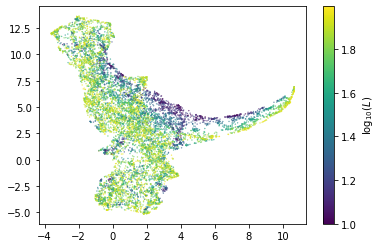

In [49]:
cm=plt.scatter(X[:,0],X[:,1],c=np.log10(info["length"]),s=.1)
plt.colorbar(cm,label="$\log_{10}(L)$")

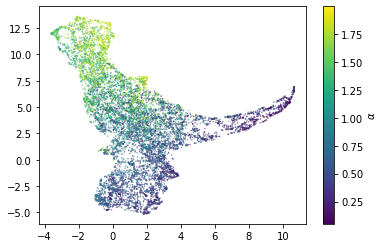

In [51]:
cm=plt.scatter(X[:,0],X[:,1],c=info["alpha"],s=.1)
plt.colorbar(cm,label="$\\alpha$")

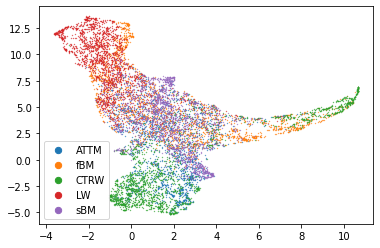

In [53]:
for m in np.unique(info["model"]):
    c = info["model"] == m
    plt.scatter(X[c,0],X[c,1],s=.1,label=dl.dataset.model_types[m])
plt.legend(markerscale=20)